## METRICS Tutorial

This tutorial will cover the 4 metrics used to assess the models' performance and create a ranking.

The four metrics are:
* Mean SQUARED Error (MSE)
* Signal to Noise Ratio (SNR)
* Linewidth
* Curve Shape (GABA and GLX)


In [2]:
# Changing path to access scripts
import sys
sys.path.insert(0,"..")

# importing libraries
import numpy as np
import matplotlib.pyplot as plt
from data_corruption import TransientMaker
import h5py

In [3]:
# Loading 1 ground truth from sample data
with h5py.File("../data/sample_data.h5") as hf:
    gt_fids = hf["ground_truth_fids"][()][:1]
    ppm = hf["ppm"][()][:1]
    t = hf["t"][()][:1]

# creating transients and adding noise
# We are using 160 transients to obtain better reconstruction
tm = TransientMaker(gt_fids.copy(),t,transients=160)

tm.add_random_amplitude_noise()
tm.add_random_frequency_noise()
tm.add_random_phase_noise()

# transforming data into single difference spectrum
gt_spec = np.fft.fftshift(np.fft.ifft(gt_fids,axis=1),axes=1)
noisy_spec = np.fft.fftshift(np.fft.ifft(tm.fids,axis=1),axes=1)
gt_diff_spec = np.real(gt_spec[0,:,1]-gt_spec[0,:,0])
noisy_diff_spec = np.real((noisy_spec[0,:,1,:]-noisy_spec[0,:,0,:]).mean(axis=1))

# changing dimension of ppm and t
ppm = ppm[0]
t = t[0]


### Mean Squared Error - MSE

The MSE metric is calculated by using the range between 2.5ppm and 4ppm and comparing the ground-truth direct reconstruction with the reconstruction spectrum

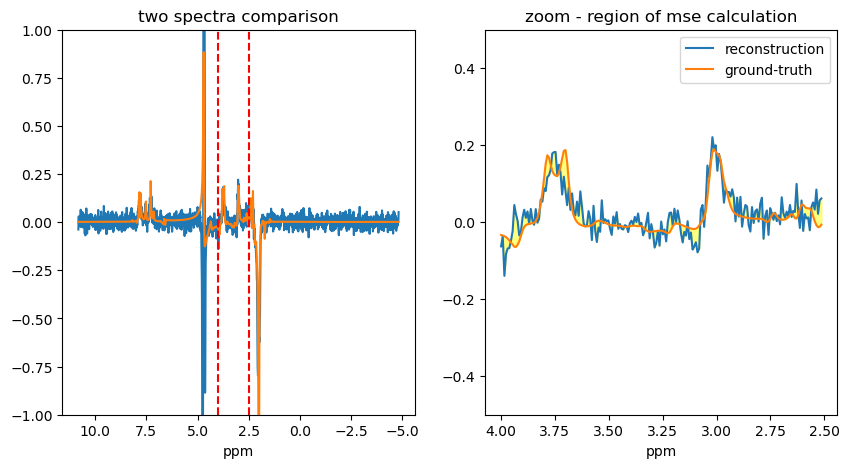

MSE: 0.0013742902107149377


In [4]:
### Calculating MSE

# Defining Region of interest and indexes
min_ppm = 2.5
max_ppm = 4
max_ind = np.amax(np.where(ppm >= min_ppm))
min_ind = np.amin(np.where(ppm <= max_ppm))

# cropping spectrum to region of interest
x_crop = noisy_diff_spec[min_ind:max_ind]
y_crop = gt_diff_spec[min_ind:max_ind]
ppm_crop = ppm[min_ind:max_ind]

# calculate MSE
mse = np.square(y_crop-x_crop).mean()

# plotting x and y spectra to and highlighting region of difference
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(ppm,noisy_diff_spec,label="reconstruction")
ax[0].plot(ppm,gt_diff_spec,label="ground-truth")
ax[0].invert_xaxis()
ax[0].set_xlabel("ppm")
ax[0].set_ylim(-1,1)
ax[0].vlines([min_ppm,max_ppm],-1,1,colors="red",linestyles="--")
ax[0].set_title("two spectra comparison")

ax[1].plot(ppm_crop,x_crop,label="reconstruction")
ax[1].plot(ppm_crop,y_crop,label="ground-truth")
ax[1].fill_between(ppm_crop,x_crop,y_crop,color="yellow",alpha=0.5)
ax[1].invert_xaxis()
ax[1].set_xlabel("ppm")
ax[1].set_ylim(-0.5,0.5)
ax[1].set_title("zoom - region of mse calculation")

plt.legend()
plt.show()

print(f"MSE: {mse}")

### Signal-to-Noise Ratio - SNR

The SNR we'll use is defined as the maximum value of the peak divided by two times the standard deviation of a region without signal, between 9.8 and 10.8ppm. This region is fitted to remove trends and better capture the noise.

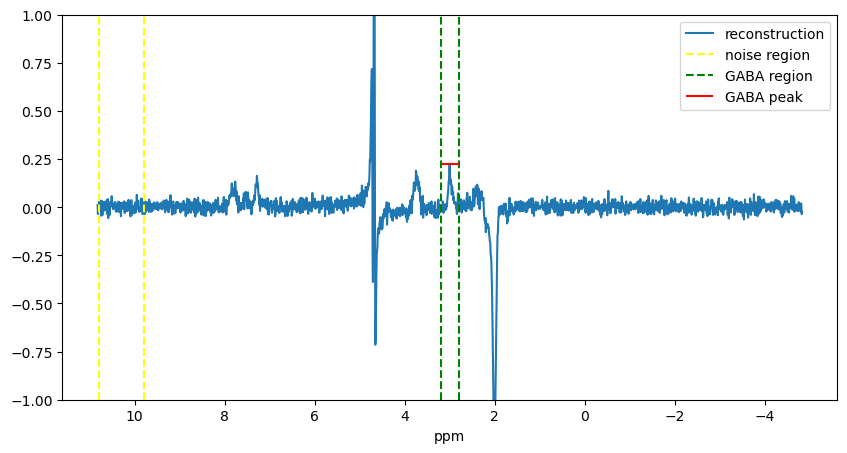

In [9]:
### calculating SNR

# Getting indexes of Region of interest
gaba_max_ind, gaba_min_ind = np.amax(np.where(ppm >= 2.8)), np.amin(np.where(ppm <= 3.2))
dt_max_ind, dt_min_ind = np.amax(np.where(ppm >= 9.8)), np.amin(np.where(ppm <= 10.8))

# get peak max value
max_peak = noisy_diff_spec[gaba_min_ind:gaba_max_ind].max()

# calculate standard deviation
dt = np.polyfit(ppm[dt_min_ind:dt_max_ind], noisy_diff_spec[dt_min_ind:dt_max_ind], 2)
sizeFreq = ppm[dt_min_ind:dt_max_ind].shape[0]
stdev_Man = np.sqrt(np.sum(np.square(np.real(noisy_diff_spec[dt_min_ind:dt_max_ind] - np.polyval(dt, i_ppm[dt_min_ind:dt_max_ind])))) / (sizeFreq - 1))

# calculate snr
snr = max_peak/(2*stdev_Man)

# plot spectrum and hightlight regions used in calculation
fig,ax = plt.subplots(figsize=(10,5))

ax.plot(ppm,noisy_diff_spec,label="reconstruction")
ax.set_ylim(-1,1)
ax.set_xlabel("ppm")
ax.invert_xaxis()
ax.vlines([9.8,10.8],-1,1,colors='yellow',linestyles='--',label="noise region")
ax.vlines([2.8,3.2],-1,1,colors='green',linestyles='--',label="GABA region")
ax.hlines(max_peak,2.8,3.2,colors='red',linestyles='-',label="GABA peak")

plt.legend()
plt.show()


### Linewidth

Linewidth, or full width at half maximum (FWHM) is defined as the difference between the ppm value of the farthest points at either side of the peak which are greater than half of the peak's height.

Only the region of the GABA peak is considered and, in order to determine the height, a min-max normalization is performed.

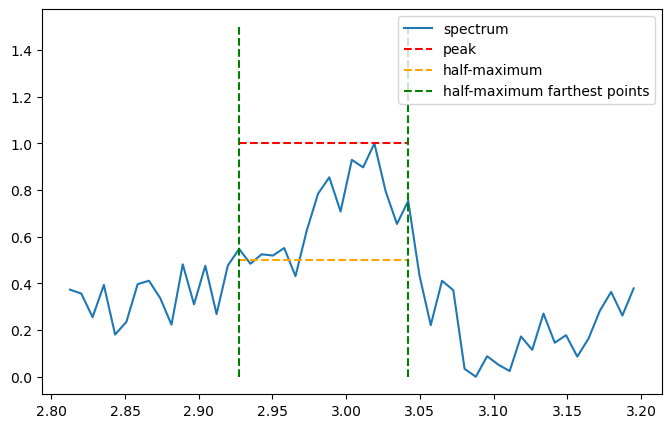

In [9]:
# selecting indexes of gaba peak region
gaba_max_ind, gaba_min_ind = np.amax(np.where(ppm >= 2.8)), np.amin(np.where(ppm <= 3.2))

# cropping spectrum for only gaba region and performin min-max normalization
ppm_crop = ppm[gaba_min_ind:gaba_max_ind]
spec = noisy_diff_spec[gaba_min_ind:gaba_max_ind]
spec = (spec-spec.min())/(spec.max()-spec.min())

# selecting max point index
max_peak = spec.max()
ind_max_peak = np.argmax(spec)

# selecting highest ppm value with point above half the peak value
left_side = spec[:ind_max_peak]
left_ind = np.amin(np.where(left_side>max_peak/2))+gaba_min_ind
left_ppm = ppm[left_ind]

# selecting lowest ppm value with point above half the peak value
right_side = spec[ind_max_peak:]
right_ind = np.amax(np.where(right_side>max_peak/2))+gaba_min_ind+ind_max_peak
right_ppm = ppm[right_ind]

# ploting peak
fig,ax = plt.subplots(figsize=(8,5))

plt.plot(ppm_crop,spec,label = "spectrum")
plt.hlines(max_peak,right_ppm,left_ppm,colors="r",linestyles="--",label="peak")
plt.hlines(max_peak/2,right_ppm,left_ppm,colors="orange",linestyles="--",label="half-maximum")
plt.vlines([right_ppm,left_ppm],0,max_peak*1.5,colors="g",linestyles="--",label="half-maximum farthest points")

plt.legend()
plt.show()


### Shape Score

The shape score is a metric to determine if the shape of the reconstructed peak is according to the expected. This is especially interesting when considering the GLX double peak at 3.75ppm.

The definition of the shape score is the weighted average of the correlation between the ground-truth spectrum and the model reconstruction, using min-max normalization and only considering the region close to each peak.

The regions were determined as from 2.8ppm to 3.2ppm for GABA, and from 3.6ppm to 3.9ppm for GLX, and their weights were 0.6 and 0.4, respectively.

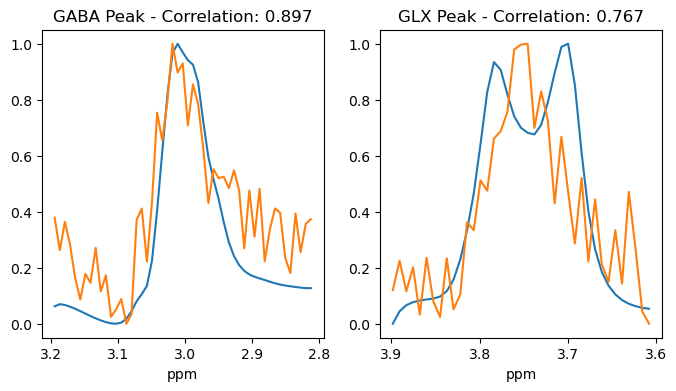

Shape Score = 0.6*GABA_corr + 0.4 GLX_corr = 0.845


In [8]:
## calculate shape score


# selecting indexes of region of interest
gaba_max_ind, gaba_min_ind = np.amax(np.where(ppm >= 2.8)), np.amin(np.where(ppm <= 3.2))
glx_max_ind, glx_min_ind = np.amax(np.where(ppm >= 3.6)), np.amin(np.where(ppm <= 3.9))

# cropping reconstruction to gaba region and performing min-max normalization
gaba_spec_x = noisy_diff_spec[gaba_min_ind:gaba_max_ind]
gaba_spec_x = (gaba_spec_x-gaba_spec_x.min())/(gaba_spec_x.max()-gaba_spec_x.min())

# cropping ground-truth spectrum to gaba region and performing min-max normalization
gaba_spec_y = gt_diff_spec[gaba_min_ind:gaba_max_ind]
gaba_spec_y = (gaba_spec_y-gaba_spec_y.min())/(gaba_spec_y.max()-gaba_spec_y.min())

# cropping ppm array to gaba region
gaba_crop_ppm = ppm[gaba_min_ind:gaba_max_ind]

# cropping reconstruction to GLX region and performing min-max normalization
glx_spec_x = noisy_diff_spec[glx_min_ind:glx_max_ind]
glx_spec_x = (glx_spec_x-glx_spec_x.min())/(glx_spec_x.max()-glx_spec_x.min())

# cropping ground-truth spectrum to GLX region and performing min-max normalization
glx_spec_y = gt_diff_spec[glx_min_ind:glx_max_ind]
glx_spec_y = (glx_spec_y-glx_spec_y.min())/(glx_spec_y.max()-glx_spec_y.min())
# cropping ppm array to GLX region
glx_crop_ppm = ppm[glx_min_ind:glx_max_ind]

# calculating correlations
gaba_corr = np.corrcoef(gaba_spec_x,gaba_spec_y)[0,1]
glx_corr = np.corrcoef(glx_spec_x,glx_spec_y)[0,1]

# plotting each region and their correlation results
fig,ax = plt.subplots(1,2,figsize=(8,4))

ax[0].plot(gaba_crop_ppm,gaba_spec_y,label='ground-truth')
ax[0].plot(gaba_crop_ppm,gaba_spec_x,label='reconstruction')
ax[0].set_xlabel("ppm")
ax[0].invert_xaxis()
ax[0].set_title(f"GABA Peak - Correlation: {gaba_corr:.3f}")

ax[1].plot(glx_crop_ppm,glx_spec_y,label='ground-truth')
ax[1].plot(glx_crop_ppm,glx_spec_x,label='reconstruction')
ax[1].set_xlabel("ppm")
ax[1].invert_xaxis()
ax[1].set_title(f"GLX Peak - Correlation: {glx_corr:.3f}")

plt.show()

# final shape score result
print(f"Shape Score = 0.6*GABA_corr + 0.4 GLX_corr = {0.6*gaba_corr+0.4*glx_corr:.3f}")
